<a href="https://colab.research.google.com/github/shinhs0920/19-lab/blob/master/AutoEncoder_Kreas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오토인코더

입력 데이터의 압축된 표현을 찾기 위한 심층 신경망 아키텍쳐

레이블이 없어도 데이터만으로 코드를 자동으로 학습한다 - 비지도 학습 알고리즘 

## 목차

- 오토인코더의 원리
- 케라스로 오토인코더 구성하기
- 잡음 제거 오토인코더(DAE)
- 자동 채색 오토인코더

## 오토인코더의 원리

#### 오토 인코더의 연산자

- **인코더** : 입력$x$를 저차원 잠재 벡터 $z=f(x)$로 변환.<br>**잠재 벡터**는 저차원이므로 **입력** 데이터에서 가장 **중요한 특징**만을 **학습**한다.
<br>ex)MNIST 숫자 데이터 특징 : 필체, 경사각, 두께 등등 

- **디코더** : 잠재 벡터  $g(z)=  \tilde{x}$로부터 **입력 데이터**를 **복원**. <br>$\tilde{x}$를 $x$에 가능한 한 가깝게 만드는 것이 목표. 

<그림1>

따라서 오토인코더는 훈련동안 **손실 함수** $L(x, \tilde{x})$를 **최소화**하려 한다.

인코더는 입력$x$을 입력의 중요 특징만 합습된 저차원 잠재 벡터$z$로 압축하고, 디코더는 잠재 벡터로부터 $\tilde{x}$ 형태로 복원한다. 

## 케라스로 오토인코더 구성하기

In [0]:
try:

    %tensorflow_version 2.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


#### 1. 인코더 모델 구성

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


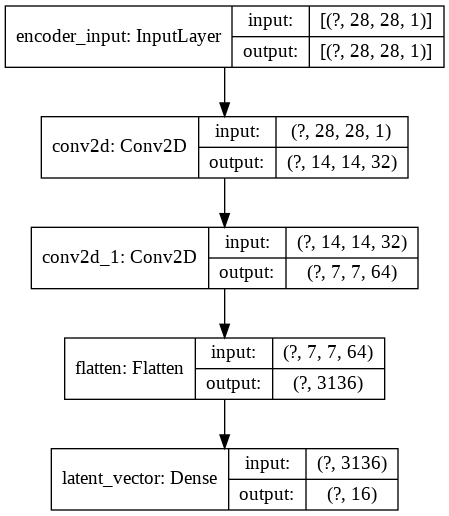

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# MINST 데이터세트 로딩
(x_train, _), (x_test, _) = mnist.load_data()

# 이미지 형상을 (28,28,1)로 조정, 입력 이미지 정규화
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 매개변수 
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16 # 잠재 벡터 : 16차원

# CNN 계층 당 필요한 인코더 / 디코더 개수
layer_filters = [32, 64]

# 오토인코더 모델 구성

# 1. 인코더 모델 구성
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# 구성 :  Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# 디코더 모델 구성에 필요한 형상의 정보
# 디코더의 첫 Conv2DTranspose의 입력은 이 형상이다.
# 형상은 (7, 7, 64)이며, 디코더에 의해 처리되면 다시 (28,28,1)로 돌아간다.
shape = K.int_shape(x)

# 잠재 벡터 생성
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# 인코더 모델 인스턴스화 
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

+) 위 summary에서 '?'는 'None'을 의미합니다.

**인코더 모델**은 **저차원 잠재 벡터 생성을 위해** Conv2D(32)-Conv2D(64)-Dense(16)으로 구성되어, **Dense 계층**에서 16차원의 **잠재 벡터를 구현**한다.

#### 2. 디코더 모델 구성 코드

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

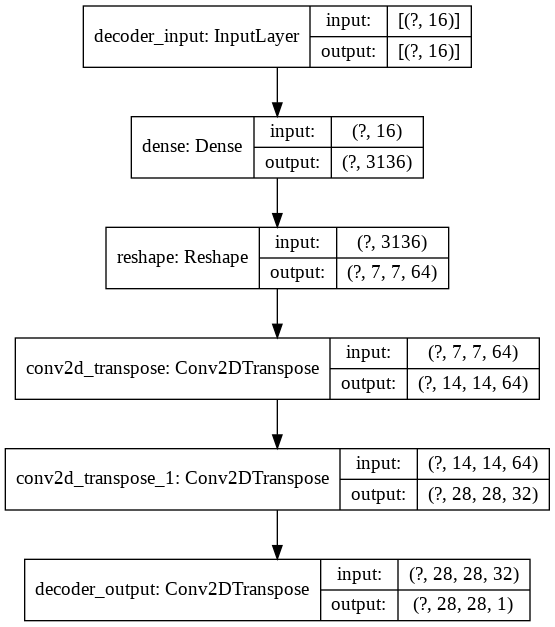

In [0]:
# 2. 디코더 모델 구성
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# 인코더 모델에서 저장한 (7,7,64) 형상 사용
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# 벡터 형상에서 전치 합성곱에 사용할 적절한 형상으로 변환
x = Reshape((shape[1], shape[2], shape[3]))(x)

# 구성 : Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# 입력을 재구성한다.
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# 디코더 모델 인스턴스화
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)


**디코더**는 MNIST **숫자 복원**을 위해 **잠재 벡터 압축을 해제**한다.
<BR>따라서 디코더의 **입력 계층**은 잠재 벡터를 받는 **Dense계층**이다.

디코더 모델은 Dense(16)-Conv2DTranspose(64)-Conv2DTranspose(32)-Conv2DTranspose(1)로 구성된다.

#### 3. 오토인코더 구성

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0207 - val_loss: 0.0107


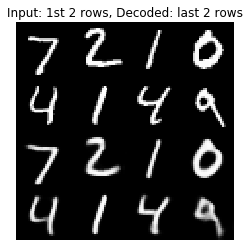

In [0]:
# 오토인코더 = 인코더 + 디코더
# 3. 오토인코더 모델 인스턴스화
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

# 평균 제곱 오차(mse) 손실함수 , Adam 최적화 사용
autoencoder.compile(loss='mse', optimizer='adam')

# 4. 오토인코더 훈련
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)

# 훈련 데이터에서 오토인코더 출력 예측
x_decoded = autoencoder.predict(x_test)

# 첫 8개 훈련 입력과 디코딩된 이미지 표시
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

위 **결과 이미지**는 **총 16개 숫자**이며, 그 중 **첫 두줄** 숫자 이미지는 **원본 입력 테스트 데이터**이며, **아래 8개** 숫자 이미지는 그에 대응하는 **디코딩 된 데이터**이다.

디코딩된 이미지가 조금 흐려졌지만 충분히 오토인코더가 입력을 복원했다고 볼 수 있다. 

아래 코드는 에폭을 더 늘려서 30으로 설정해 보았다.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0099 - val_loss: 0.0091
Epoch 2/30
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0088 - val_loss: 0.0086
Epoch 3/30
60000/60000 [==============================] - 10s 159us/sample - loss: 0.0082 - val_loss: 0.0080
Ep

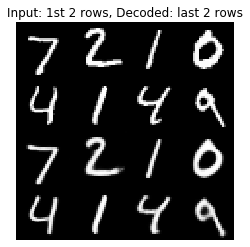

In [0]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=30, # 에폭을 30배하며 30으로 설정하였다.
                batch_size=batch_size)

x_decoded = autoencoder.predict(x_test)

imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

1에폭일 때의 결과보다 30에폭일 때의 디코딩된 이미지가 더 뚜렷함을 볼 수있다.
<br>따라서, **많은 에폭을 수행**할수록 **결과는 더 개선**된 모습을 볼 수 있었다.

## 잡음 제거 오토인코더(DAE)

이미지에 잡음이 섞여 훼손되어 구별하기 힘든 경우, 잡음을 제거하기 위해 DAE가 사용된다.

<그림>

위 그림은 세 개의 MNIST 숫자 집합을 나타낸 그림이다.

<BR> 각 집합의 **첫 번째** 줄은 **원본 이미지**이다.
<BR>**중간** 줄은 원본이미지를 **잡음으로 훼손한**  DAE에 입력시킬 **이미지**이다
<BR>**마지막** 줄은 **DAE 출력**이다.

<그림>

따라서 DAE의 입력은 잡음으로 훼손된 이미지이며, 출력은 잡음이 제거된 깨끗한 이미지이다. 

아래 코드는 DAE 코드이다.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

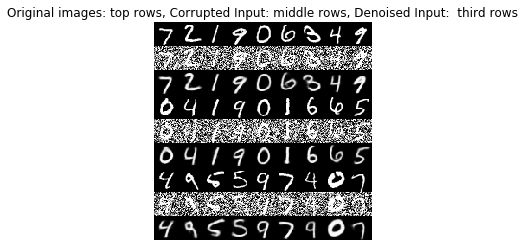

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 난수를 생성한다.
np.random.seed(1337)

# MINST 데이터세트 로딩
(x_train, _), (x_test, _) = mnist.load_data()

# 형태 변환 및 정규화
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 평균 0.5, 표준편차 0.5의 정규 분포를 따르는 잡음 추가 -> 훼손된 MNIST 이미지 생성
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

# 잡음 추가 시, 정규화된 픽셀 값이 0.0보다 작거나 1.0보다 커질 수 있다.
# 따라서, 1.0보다 큰 값은 1.0으로, 0.0보다 작은 값은 0.0으로 고정시킨다.
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# 매개변수
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

# 오토인코더 모델 구성

# 인코더 모델 구성
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(32)-Conv2D(64) 구조
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)

# 잠재 벡터 생성
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# 인코더 모델 인스턴스화
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# 디코더 모델 구성
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Conv2DTranspose(64)-Conv2DTranspose(32) 구조
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# 잡음이 제거된 입력 재구성
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# 디코더 모델 인스턴스화
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# 오토인코더 모델 인스턴스화
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# mse 손실함수 및 Adam 최적화
autoencoder.compile(loss='mse', optimizer='adam')

# 오토인코더 훈련
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

# 훼손된 테스트 이미지에서 오토인코더 출력 예측
x_decoded = autoencoder.predict(x_test_noisy)

# 9개의 MINST 숫자로 만든 3개의 이미지 집합 구성
# 첫번째 줄 - 원본 이미지
# 두번째 줄 - 잡음으로 훼손된 이미지
# 세번쨰 줄 - 잡음이 제거된 이미지
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

위 결과 이미지에서 DAE는 많은 이미지 중 세번째 집합의 4와 같이 아주 소량의 데이터만 잘 인식하지 못하였다.
<BR>사람조차 훼손된 이미지를 잘 해석하지 못하는 것을 고려하였을때 꽤 DAE의 성능이 좋다고 할 수 있다.

## 자동 채색 오토인코더

이번엔 흑백 사진에 사물마다 특정한 색을 자동으로 입혀보려 한다.

<그림>

위 그림은 앞에 논이 펼쳐져 있고 뒤에는 화산이 보이며 그 위에는 하늘이 있는 흑백사진이며 각각에 맞게 적절한 색을 입히려한다.

이번에는 CIFAR10 데이터베이스를 사용한다. 흑백으로 변환될 수 있는 32$\times$32 RGB 사진이 5만개 훈련 집합과 1만개의 테스트 집합으로 구성되어 있다.

아래 코드는 CIFAR10 데이터세트를 사용하는 자동 채색 오토인코더를 나타낸다.

170500096/170498071 [==============================] - 4s 0us/step


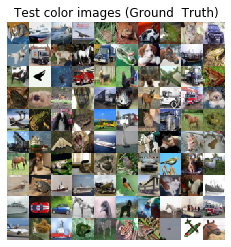

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

# 컬러를 흑백으로 변환하기 위해 rgb2gray()함수를 사용한다.
# R,G,B 요소에 가중치 적용
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# CIFAR10 데이터 로딩
(x_train, _), (x_test, _) = cifar10.load_data()

# 입력 이미지 차원 - '마지막'에 '채널'이 온다고 가정.
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# saved_images 폴더 생성
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# 처음 100개의 입력 이미지(컬러&흑백)를 표시
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

이렇게 CIFAR10 데이터 베이스를 컬러로 나타냈다.

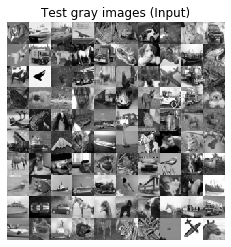

In [0]:
# 컬러 훈련 / 테스트 이미지를 흑백으로 변환
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# 테스트 이미지의 흑백 버전 표시
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

앞선 컬러 이미지를 흑백으로 변환하였다.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

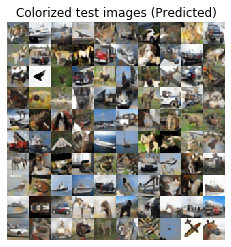

In [10]:
# 출력 훈련 / 테스트 컬러 이미지 정규화
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 입력 훈련 / 테스트 컬러 이미지 정규화
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# CNN 출력 / 검증 위해 이미지 형상을 row x col x channel로 변경
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# CNN 입력을 위해 이미지 형상을 row x col x channel로 변경
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

# 매개변수
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

# 오토인코더 모델 구성
# 먼저, 인코더 모델 구성
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
# 이번에는 디코더의 첫 Conv2DTranspose에 들어갈 형상은 (4,4,256)이다.
# 디코더에서는 (32,32,3)으로 처리된다.
shape = K.int_shape(x)

# 잠재 벡터 생성       
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# 인코더 모델 인스턴스화   
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# 디코더 모델 구성
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# 디코더 모델 인스턴스화
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# 오토인코더 모델 인스턴스화
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# 모델을 저장할 directory 준비
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# 손실 값이 5에폭 내에 개선되지 않으면,
# 학습 속도를 sqrt(0.1)을 사용해 감소시킨다.
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# 가중치 저장 - 추가적인 훈련과정 없이 매개변수 불러온다.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

autoencoder.compile(loss='mse', optimizer='adam')

# 에폭마다 호출
callbacks = [lr_reducer, checkpoint]

# 오토인코더 훈련
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

# 훈련 데이터로부터 오토인코더 출력 예측
x_decoded = autoencoder.predict(x_test_gray)

# 첫 100개의 채색된 이미지 표시
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

흑백 이미지와 결과 컬러 이미지를 비교하면 꽤 많은 이미지가 적절하게 채색됨을 알 수 있다. 물론, 중간에 일부 잘못 채색된 이미지도 있다.

위 코드는 오토인코더에 CNN과 전치 합성곱 블록을 하나 더 추가했다. 또한 각 CNN마다 필터개수를 두 배로 늘렸다.  

잠재 벡터는 이미지의 핵심 속성의 개수를 늘리기 위해 256차원이 되었다. 출력 필터 크기는 본래 입력 값 1에서 3으로 증가하였으나 이는 예상 출력의 RGB 채널 개수인 3과 같다.

이로써, 채색 오토인코더는 입력으로는 흑백 이미지, 출력으로는 원본 RGB 이미지를 사용해 훈련된다.

훈련은 많은 에폭을 거치게 되고, 검증 손실 값이 줄어들지 않는다면 학습 속도를 줄이기 위해 학습 속도 감소법을 사용할 것이다.